# SATCAT EDA - Down the Rabbit Hole!

This is where I really want to start digging in to my second datasets data.  Ive done a few things up to this point, a couple of visualizations, but I want to really explore a bit more of the data included.  I want to see if there is any other useful data that may help me ask and answer additional questions I havn't thought of yet. Here we can also handle any currently missing and or invalid data that wasn't taken care of during cleaning while we actively explore that data to tell its story.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
clutter_data = pd.read_csv('../../data/clean/orbital_clutter_cleaned.csv')

print(f"Loaded {len(clutter_data)} objects.\n")
print(clutter_data['category'].value_counts())
clutter_data.head(10)

Loaded 32695 objects.

category
Debris                12662
Inactive Satellite    11978
Active Satellite       5610
Rocket Body            2397
Unknown                  48
Name: count, dtype: int64


,object_name,object_id,norad_id,object_type,ops_status,owner,launch_date,launch_site,decay_date,period_minutes,inclination_degrees,apogee_km,perigee_km,rcs,data_status,orbit_center,orbit_type,orbit_class,users,purpose,launch_mass_kg,source,launch_year,decay_year,category,proxy_mass_kg
0,VANGUARD 1,1958-002B,5,PAY,NaN,US,1958-03-17,AFETR,NaN,132.60,34.25,3820.0,651.0,0.1220,NaN,EA,ORB,MEO,NaN,NaN,NaN,left_only,1958,NaN,Inactive Satellite,1000.0
1,VANGUARD 2,1959-001A,11,PAY,NaN,US,1959-02-17,AFETR,NaN,120.99,32.88,2898.0,552.0,0.3931,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1959,NaN,Inactive Satellite,1000.0
2,VANGUARD R/B,1959-001B,12,R/B,NaN,US,1959-02-17,AFETR,NaN,125.38,32.90,3287.0,553.0,0.5266,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1959,NaN,Rocket Body,2000.0
3,VANGUARD R/B,1958-002A,16,R/B,NaN,US,1958-03-17,AFETR,NaN,137.20,34.27,4216.0,651.0,0.2282,NaN,EA,ORB,MEO,NaN,NaN,NaN,left_only,1958,NaN,Rocket Body,2000.0
4,VANGUARD 3,1959-007A,20,PAY,NaN,US,1959-09-18,AFETR,NaN,123.95,33.35,3207.0,506.0,0.6412,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1959,NaN,Inactive Satellite,1000.0
5,EXPLORER 7,1959-009A,22,PAY,NaN,US,1959-10-13,AFETR,NaN,94.45,50.24,551.0,434.0,0.5003,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1959,NaN,Inactive Satellite,1000.0
6,PIONEER 5,1960-001A,27,PAY,NaN,US,1960-03-11,AFETR,NaN,NaN,NaN,NaN,NaN,0.0008,NEA,SU,ORB,Unknown,NaN,NaN,NaN,left_only,1960,NaN,Inactive Satellite,1000.0
7,TIROS 1,1960-002B,29,PAY,-,US,1960-04-01,AFETR,NaN,97.40,48.38,650.0,618.0,0.8030,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1960,NaN,Inactive Satellite,1000.0
8,TRANSIT 2A,1960-007A,45,PAY,NaN,US,1960-06-22,AFETR,NaN,100.29,66.69,956.0,589.0,0.4299,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1960,NaN,Inactive Satellite,1000.0
9,SOLRAD 1 (GREB),1960-007B,46,PAY,NaN,US,1960-06-22,AFETR,NaN,99.00,66.69,845.0,576.0,0.3501,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1960,NaN,Inactive Satellite,1000.0


In [3]:
# Create the crosstab (Orbit Class vs Category)
orbit_composition = pd.crosstab(
    clutter_data['orbit_class'], 
    clutter_data['category'], 
    normalize='index'
) * 100 # Multiply by 100 to convert to percentage.

orbit_composition

category,Active Satellite,Debris,Inactive Satellite,Rocket Body,Unknown
orbit_class,,,,,
GEO,37.281553,7.249191,43.042071,12.427184,0.000000
High Elliptical / Deep,8.544304,9.177215,50.316456,31.962025,0.000000
LEO,18.071836,38.604599,39.404869,3.745867,0.172828
MEO,4.912573,57.202331,12.184291,25.673050,0.027755
Unknown,3.252033,30.081301,36.910569,29.593496,0.162602


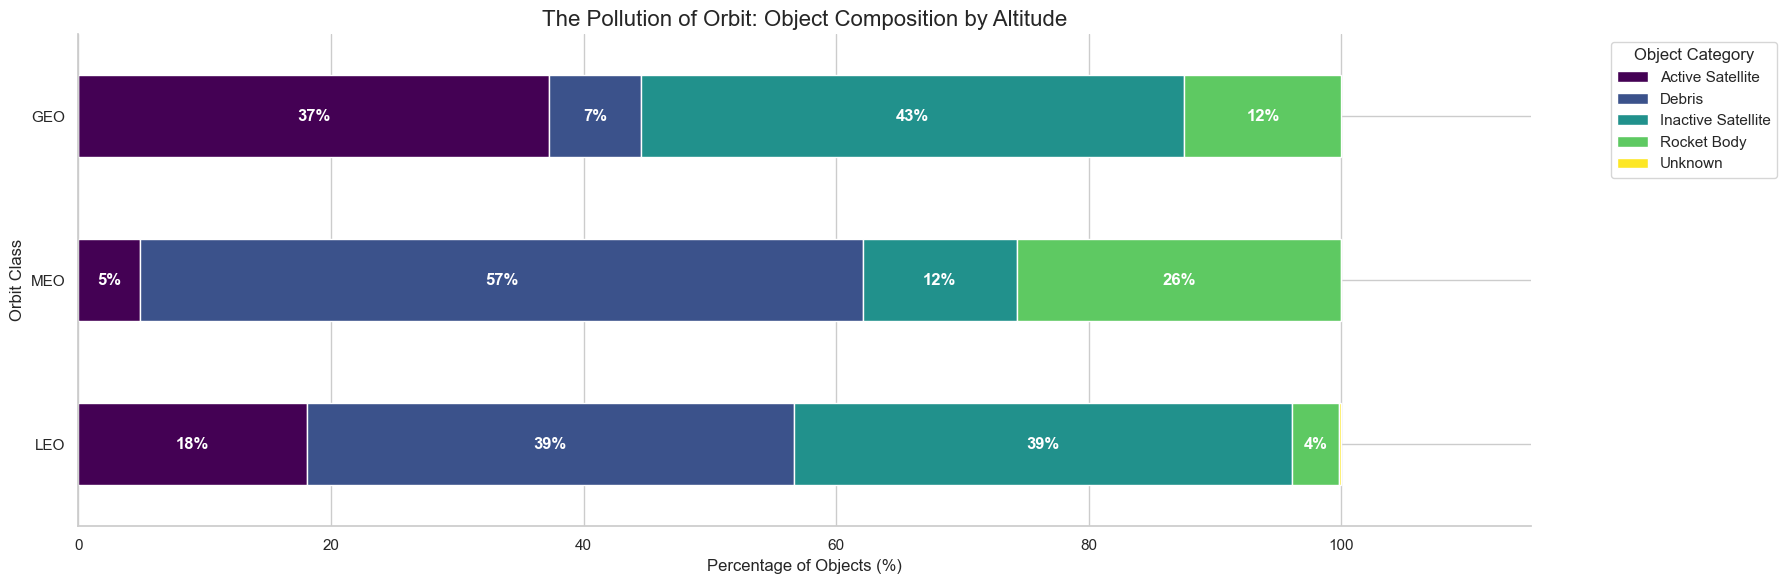

In [4]:
# Filter off elliptical and unknown orbits.
orbit_composition = orbit_composition.loc[['LEO', 'MEO', 'GEO']]

ax = orbit_composition.plot(
    kind='barh', 
    stacked=True, 
    figsize=(18, 6), 
    colormap='viridis'
)

plt.title('The Pollution of Orbit: Object Composition by Altitude', fontsize=16)
plt.xlabel('Percentage of Objects (%)')
plt.ylabel('Orbit Class')

plt.legend(title='Object Category', bbox_to_anchor=(1.05, 1), loc='upper left')

for c in ax.containers:
    # Create custom labels: Only show text if the value is > 0 because the 0 is getting smashed at the end of the visualization.
    # v.get_width() gets the size of the bar segment
    labels = [f'{v.get_width():.0f}%' if v.get_width() > 1 else '' for v in c]
    
    # Apply the custom labels
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontweight='bold')

plt.xlim(0, 115) # Extends the x-axis to 115% to make room for labels

sns.despine()
plt.tight_layout()
plt.show()

In [5]:
# Who are the top 10 contributors to the debris
top_contributors_list = clutter_data['owner'].value_counts().head(10).index
  # value_counts(): creates a summary where the unique owners are the index and then number of satellites they own are the values, sorted from highest to lowest count.
  # head(10): limits this summary to only the first 10 entries ( the top 10 owners with the most satellites).
  # index: strips away the actual counts (the numbers) and returns only the labels(the names of those 10 owners).

print(top_contributors_list)
print(top_contributors_list[0:10])
print(f'List<string>: {top_contributors_list.tolist()}') # Similar to a generic list in C# (List<string>)

Index(['US', 'CIS', 'PRC', 'UK', 'FR', 'JPN', 'IND', 'TBD', 'ITSO', 'ESA'], dtype='object', name='owner')
Index(['US', 'CIS', 'PRC', 'UK', 'FR', 'JPN', 'IND', 'TBD', 'ITSO', 'ESA'], dtype='object', name='owner')
List<string>: ['US', 'CIS', 'PRC', 'UK', 'FR', 'JPN', 'IND', 'TBD', 'ITSO', 'ESA']


In [6]:
# Filter the main dataset to only include these top 10
top_contributors_data = clutter_data[clutter_data['owner'].isin(top_contributors_list)]

top_contributors_data

,object_name,object_id,norad_id,object_type,ops_status,owner,launch_date,launch_site,decay_date,period_minutes,inclination_degrees,apogee_km,perigee_km,rcs,data_status,orbit_center,orbit_type,orbit_class,users,purpose,launch_mass_kg,source,launch_year,decay_year,category,proxy_mass_kg
0,VANGUARD 1,1958-002B,5,PAY,NaN,US,1958-03-17,AFETR,NaN,132.60,34.25,3820.0,651.0,0.1220,NaN,EA,ORB,MEO,NaN,NaN,NaN,left_only,1958,NaN,Inactive Satellite,1000.0
1,VANGUARD 2,1959-001A,11,PAY,NaN,US,1959-02-17,AFETR,NaN,120.99,32.88,2898.0,552.0,0.3931,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1959,NaN,Inactive Satellite,1000.0
2,VANGUARD R/B,1959-001B,12,R/B,NaN,US,1959-02-17,AFETR,NaN,125.38,32.90,3287.0,553.0,0.5266,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1959,NaN,Rocket Body,2000.0
3,VANGUARD R/B,1958-002A,16,R/B,NaN,US,1958-03-17,AFETR,NaN,137.20,34.27,4216.0,651.0,0.2282,NaN,EA,ORB,MEO,NaN,NaN,NaN,left_only,1958,NaN,Rocket Body,2000.0
4,VANGUARD 3,1959-007A,20,PAY,NaN,US,1959-09-18,AFETR,NaN,123.95,33.35,3207.0,506.0,0.6412,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,1959,NaN,Inactive Satellite,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32690,STARLINK-36496,2026-002AA,67329,PAY,+,US,2026-01-04,AFETR,NaN,90.03,43.00,277.0,275.0,NaN,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,2026,NaN,Inactive Satellite,1000.0
32691,STARLINK-36483,2026-002AB,67330,PAY,+,US,2026-01-04,AFETR,NaN,90.02,43.00,276.0,274.0,NaN,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,2026,NaN,Inactive Satellite,1000.0
32692,STARLINK-36494,2026-002AC,67331,PAY,+,US,2026-01-04,AFETR,NaN,90.04,43.00,277.0,275.0,NaN,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,2026,NaN,Inactive Satellite,1000.0
32693,STARLINK-36492,2026-002AD,67332,PAY,+,US,2026-01-04,AFETR,NaN,90.02,43.00,277.0,274.0,NaN,NaN,EA,ORB,LEO,NaN,NaN,NaN,left_only,2026,NaN,Inactive Satellite,1000.0


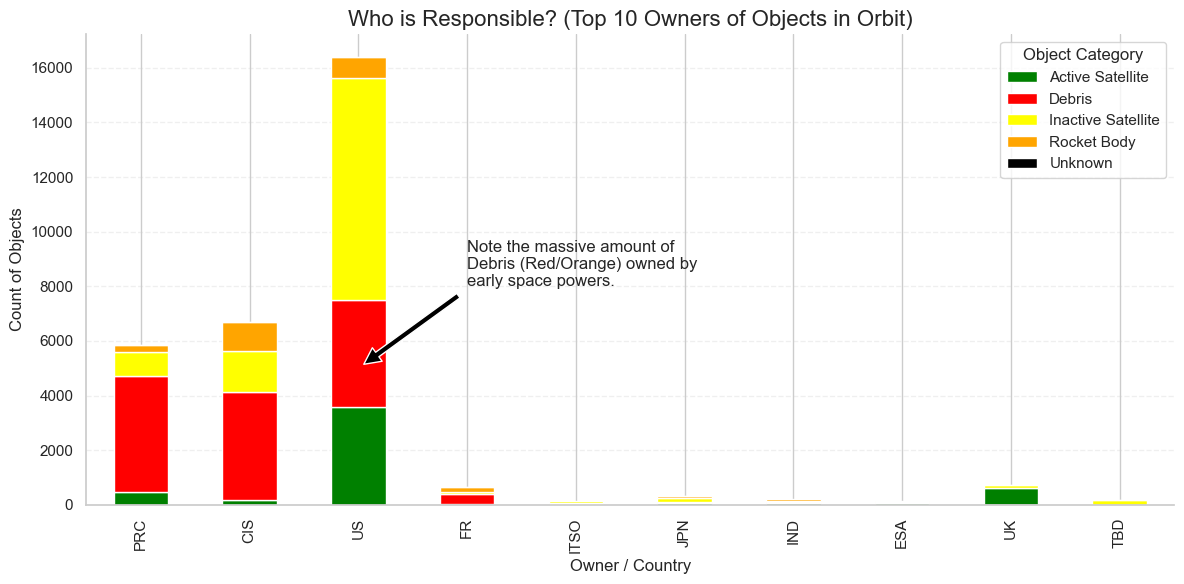

In [7]:
# Create the Crosstab (Owner vs. Category)
contributor_breakdown = pd.crosstab(
    top_contributors_data['owner'], 
    top_contributors_data['category']
)

# Sort by total count so the biggest contributor is on the left
contributor_breakdown = contributor_breakdown.sort_values(
    by=['Debris', 'Rocket Body', 'Inactive Satellite', 'Active Satellite', 'Unknown'], 
    ascending=False
)

color_map = {
  'Debris': 'red',
  'Rocket Body': 'orange',
  'Inactive Satellite': 'yellow',
  'Active Satellite': 'green',
  'Unknown': 'black' 
}

column_colors = [color_map.get(col, 'black') for col in contributor_breakdown.columns]

ax = contributor_breakdown.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6), 
    color=column_colors
)

plt.title('Who is Responsible? (Top 10 Owners of Objects in Orbit)', fontsize=16)
plt.ylabel('Count of Objects')
plt.xlabel('Owner / Country')
plt.legend(title='Object Category')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add a text annotation to highlight the "Old Space" trend
plt.annotate('Note the massive amount of \nDebris (Red/Orange) owned by \nearly space powers.', 
             xy=(2, 5000), 
             xytext=(3, 8000),
             arrowprops=dict(facecolor='black', shrink=0.05))

sns.despine()
plt.tight_layout()
plt.show()

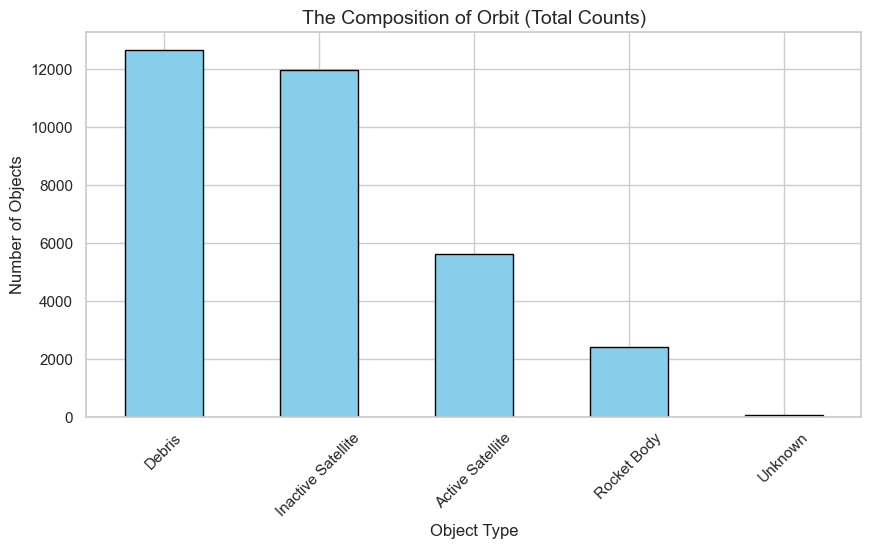

In [8]:
plt.figure(figsize=(10, 5))

# pattern: data_column -> count -> plot
clutter_data['category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('The Composition of Orbit (Total Counts)', fontsize=14)
plt.ylabel('Number of Objects')
plt.xlabel('Object Type')
plt.xticks(rotation=45)

plt.show()

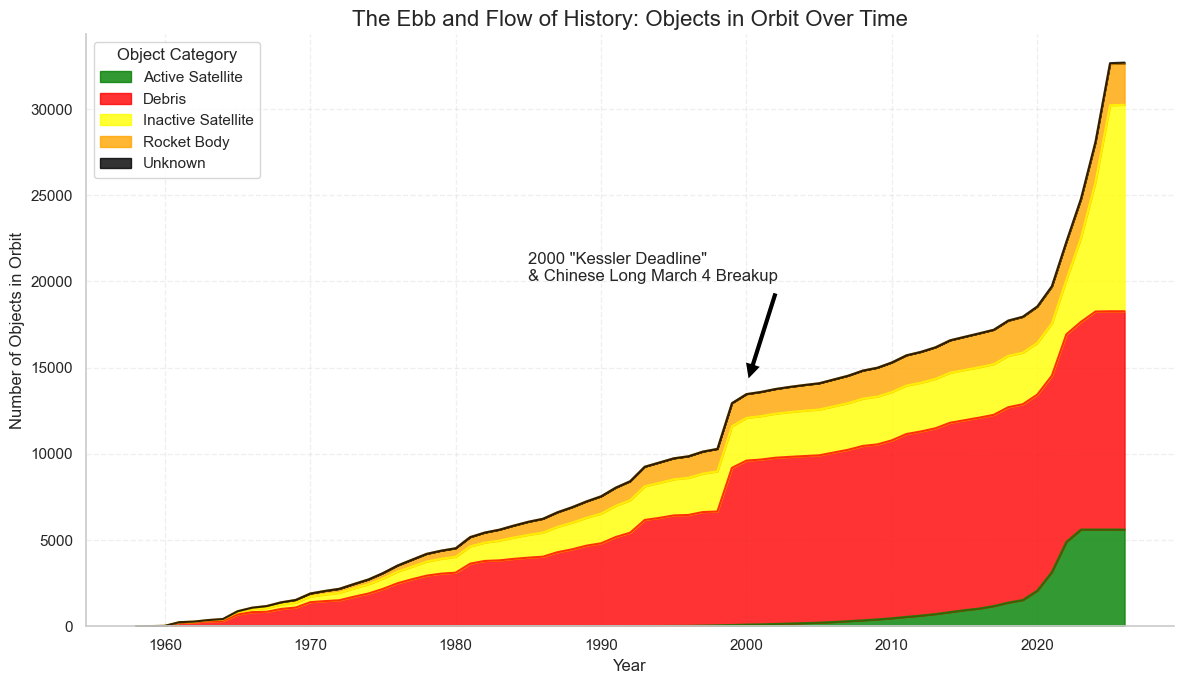

In [9]:
# count up all of the number of objects launched into splace, +1 for each.
launches = clutter_data[['launch_year', 'category']].copy()
launches['change'] = 1
launches.rename(columns={'launch_year': 'year'}, inplace=True)

# count up all of the number of ojects that have decayed from orbit, which were once launched into splace, -1 for each.
decays = clutter_data.dropna(subset=['decay_year'])[['decay_year', 'category']].copy()
decays['change'] = -1
decays.rename(columns={'decay_year': 'year'}, inplace=True)

# Now we stack them to create a list of every time something was launched or dacayed in space.
timeline = pd.concat([launches, decays])

# collect and sum up all entries for the same year.
annual_changes = timeline.groupby(['year', 'category'])['change'].sum().unstack(fill_value=0) # NaN/nill/None replaced with 0 so math can be done on the value.

# annual_changes basically tells the net shipments for the year ( in 2026 +500 items arrived).
# cumsum() tells you the total inventory currently sitting in the warehouse by adding that +500 to everything that was already there from previous years.
objects_in_orbit = annual_changes.cumsum()

current_year = pd.Timestamp.now().year

# objects_in_orbit.loc[1957:current_year] will successfully select all rows from the start label 1957 through and including the end label current_year
objects_in_orbit = objects_in_orbit.loc[1957:current_year]

color_map = {
  'Debris': 'red',
  'Rocket Body': 'orange',
  'Inactive Satellite': 'yellow',
  'Active Satellite': 'green',
  'Unknown': 'black' 
}

# get the color from the corresponding color map for each color.  Return black if not found.
column_colors = [color_map.get(col, 'black') for col in contributor_breakdown.columns]

ax = objects_in_orbit.plot(
    kind='area', 
    stacked=True, 
    figsize=(12, 7),
    color=column_colors, # substitue our colors
    alpha=0.8
)

plt.title('The Ebb and Flow of History: Objects in Orbit Over Time', fontsize=16)
plt.ylabel('Number of Objects in Orbit')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Object Category', loc='upper left')

# annotation for a large debris causing event in the year 2000
plt.annotate('2000 "Kessler Deadline" \n& Chinese Long March 4 Breakup', 
             xy=(2000, 14000), 
             xytext=(1985, 20000),
             arrowprops=dict(facecolor='black', shrink=0.05))

sns.despine() # remove top and right side splines, looks cleaner/more professional

# automatically adjusts the subplot parameters (like padding) so that elements such as tick labels, axis labels, 
# and titles do not overlap and generally fit within the figure area
plt.tight_layout() 

plt.show()

In [10]:
null_counts = clutter_data.isnull().sum()

columns_with_nulls = null_counts[null_counts > 0]

print("Columns with possibly missing/invalid data (Null Count > 0):")
print(columns_with_nulls)

null_pct = (clutter_data.isnull().sum() / len(clutter_data)) * 100
null_report = null_pct[null_pct > 0].sort_values(ascending=False)

print("\nPercentage of Missing Data per Column:")
print(null_report.map("{:.2f}%".format))

Columns with possibly missing/invalid data (Null Count > 0):
ops_status             16671
decay_date             32695
period_minutes           615
inclination_degrees      615
apogee_km                615
perigee_km               615
rcs                    17896
data_status            31755
users                  27085
purpose                27085
launch_mass_kg         27085
decay_year             32695
proxy_mass_kg             48
dtype: int64

Percentage of Missing Data per Column:
decay_date             100.00%
decay_year             100.00%
data_status             97.12%
users                   82.84%
purpose                 82.84%
launch_mass_kg          82.84%
rcs                     54.74%
ops_status              50.99%
period_minutes           1.88%
apogee_km                1.88%
inclination_degrees      1.88%
perigee_km               1.88%
proxy_mass_kg            0.15%
dtype: object


# decay_date, decay_year

In this paticular dataset, decay_date and decay_year should both be null.  This dataset was specifically built by filtering for objects with null decay_date/decay_year. If the decay_date/decay_year is not null then it means that the object decayed/deorbited. We do not need to include any objects that have already decayed/deorbited, this dataset should only contain objects currently in orbit.

# data_status
Data status is essentially the tracking data for our catalog objects. Basically this data tells us which objects have healthy tracking and which objects are either lost, too small to track consistently, or lacks a publicly available flight path.

In orbital mechanics data, a null status code is actually a good thing. A null status code indicates that the object is being tracked normally. What few rows that do have a value are usually flagged as NCE (No Current Elements).

 * NaN - Standard/Healthy - Object is being tracked normally with a standard TLE (Two-Line Element).
 * NEA - No Elements Available - Object has been identified and entered into the catalog, but there is no publicly available orbital data (Two-Line Elements or TLEs) for it.
 * NCE - No Current Elements - Object is still in orbit, but it hasnt been successfully tracked recently enough to update its orbital path.
 * NIE - No Initial Elements - This object was detected, but a stable initial orbit was never established.  This often happens with very small fragments from a new breakup.
 * TBA - To Be Assigned - A placeholder for a newly detected object that hasn't been fully categorized yet.
 * ANA - Analytic - This is a "special" record used for objects that are either lost or have unique orbital properties that dont fit standard tracking models.

In [11]:
print(clutter_data.groupby('category')['data_status'].size())
clutter_data.groupby('category')['data_status'].count()

category
Active Satellite       5610
Debris                12662
Inactive Satellite    11978
Rocket Body            2397
Unknown                  48
Name: data_status, dtype: int64


category
Active Satellite      107
Debris                211
Inactive Satellite    447
Rocket Body           175
Unknown                 0
Name: data_status, dtype: int64


Nulls should not be dropped, they represent the 'healthy' portion of the catalog.

# Conjecture

You will likely find that the vast majority of unhealthy tracking belongs the `Debris` category as it naturally would seem harder to track unintentional debris / small debris objects created from collisions, payload staging (bolts, clamps, springs), etc.

# Analysis & Evidence

While small debris fragments are often the focus of orbital safety, my analysis of the data_status tracking codes reveals that inactive Satellites, intact but dead payloads, account for nearly 50% (47.6%) of all objects currently experiencing tracking issues (such as 'No Elements Available'). This suggests that large, uncontrolled 'zombie' satellites are a primary driver of uncertainty in our orbital maps.


In [12]:
tracking_grid = pd.crosstab(
    clutter_data['category'], 
    clutter_data['data_status'],
    margins=True
)

tracking_grid

data_status,NCE,NEA,NIE,All
category,,,,
Active Satellite,4,103,0,107
Debris,0,211,0,211
Inactive Satellite,7,438,2,447
Rocket Body,0,172,3,175
All,11,924,5,940


In [13]:
unhealthy_mask = clutter_data['data_status'].notnull()

unhealthy_counts = clutter_data[unhealthy_mask]['category'].value_counts()

unhealthy_counts

category
Inactive Satellite    447
Debris                211
Rocket Body           175
Active Satellite      107
Name: count, dtype: int64

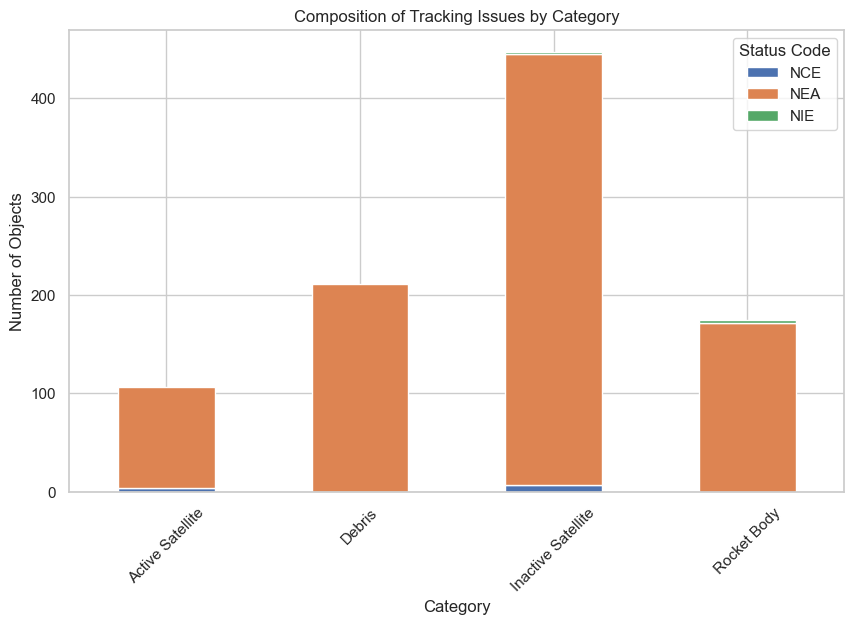

In [14]:
unhealthy_only = clutter_data.loc[unhealthy_mask]

pd.crosstab(unhealthy_only['category'], unhealthy_only['data_status']).plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6)
)

plt.title('Composition of Tracking Issues by Category')
plt.ylabel('Number of Objects')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Status Code')
plt.show()

# Simplification

While the SATCAT provides several technical status codes (NEA, NCE, NIE), lets consolidate these into a binary `Tracking Issue` category.  This simplification allows for a clearer analysis of the `Visibility Gap`, focusing on the operational risk of unmonitored objects rather than the specific technical reason for a tracking failure.

In [15]:
clutter_data['tracking_health'] = clutter_data['data_status'].apply(
    lambda x: 'Healthy/Tracked' if pd.isnull(x) else 'Tracking Issue'
)

health_summary = pd.crosstab(clutter_data['category'], clutter_data['tracking_health'])
print(health_summary)

tracking_health     Healthy/Tracked  Tracking Issue
category                                           
Active Satellite               5503             107
Debris                        12451             211
Inactive Satellite            11531             447
Rocket Body                    2222             175
Unknown                          48               0


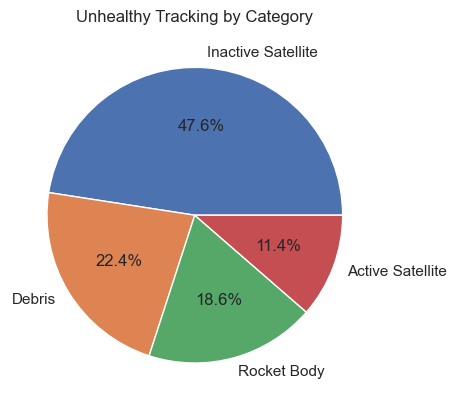

In [16]:
plt.pie(unhealthy_counts, labels=unhealthy_counts.index, autopct='%1.1f%%')

plt.title('Unhealthy Tracking by Category')
plt.show()

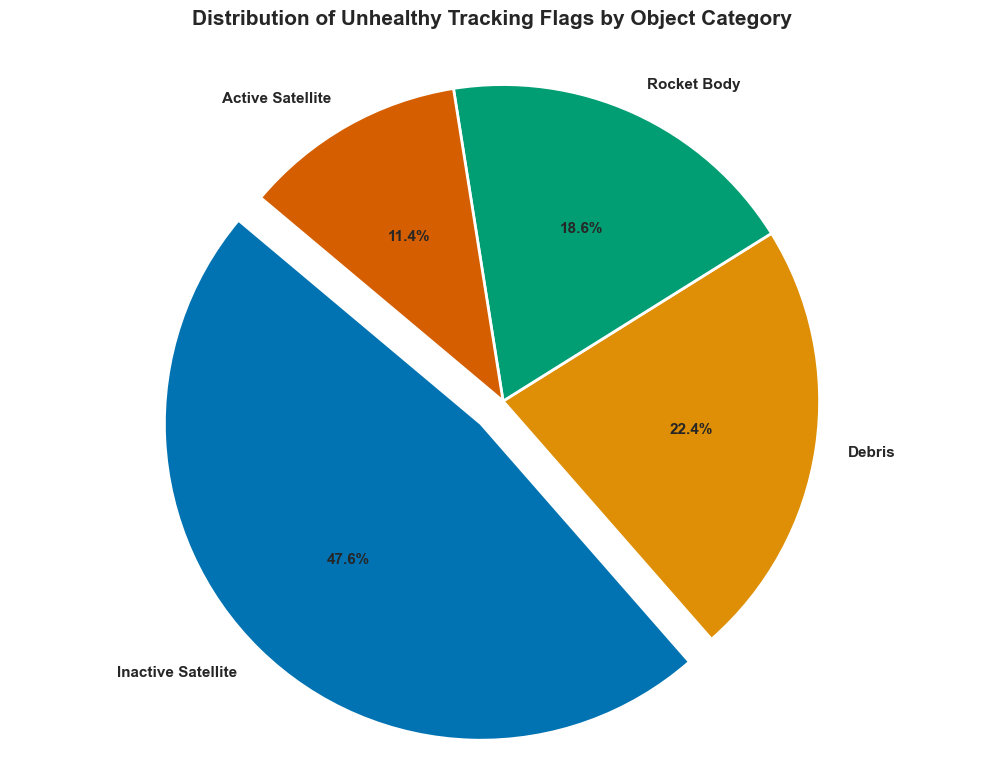

In [17]:
colors = sns.color_palette("colorblind", len(unhealthy_counts))

explode = [0.1 if idx == 'Inactive Satellite' else 0 for idx in unhealthy_counts.index]

plt.figure(figsize=(10, 8))

plt.pie(unhealthy_counts, 
        labels=unhealthy_counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=colors, 
        explode=explode, 
        shadow=False, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},
        textprops={'fontsize': 11, 'fontweight': 'bold'})

plt.title('Distribution of Unhealthy Tracking Flags by Object Category', 
          fontsize=15, 
          pad=20, 
          fontweight='bold')

plt.axis('equal') 
plt.tight_layout()
plt.show()

### **The Kessler Syndrome: The Threshold of Orbital Sustainability**

https://en.wikipedia.org/wiki/Kessler_syndrome

The **Kessler Syndrome** (proposed by NASA scientist Donald J. Kessler in 1978) is a theoretical scenario where the density of objects in Low Earth Orbit (LEO) becomes high enough that a single collision creates a cascade of debris. This debris then triggers further collisions, leading to an exponential growth of orbital junk that could eventually render space flight and satellite communication impossible.

**Key Indicators of the Syndrome in this Dataset:**
* **Exponential Growth:** A shift from steady, linear launches to a "hockey stick" curve of new objects.
* **The Fragmentation Legacy:** "Smoking gun" events (like the 2007 and 2009 spikes) that demonstrate how one event generates thousands of long-term hazards.
* **The Visibility Gap:** The presence of large, "unhealthy" Inactive Satellites that act as uncontrolled kinetic fuel for future collision cascades.

*In the following visualizations, we look for evidence that the orbital environment is moving away from a managed "wilderness" and toward a self-sustaining collision cycle.*

### **The Double Threat: Analyzing Population and Mass**

While tracking the number of objects is vital, the true danger of the Kessler Syndrome lies in the **Cumulative Mass**. A collision between two massive, dead payloads creates significantly more debris than a collision involving a small fragment. 

In the **Data Cleanup** phase, I merged high-fidelity mass data from the UCS dataset into the SATCAT Catalog using the unique NORAD ID. This allows us to visualize not just the growth of "junk" by count, but the accumulation of "Kinetic Fuel" currently sitting in orbit.

In [18]:
# build the dataframe that will be used to tell the Kessler story arc.
# The 'launch_mass_kg' column was brought in during the cleanup phase.
kessler_arc = clutter_data.sort_values('launch_date').copy()

# For this 'Conservative Lower Bound' visualization, we temporarily treat 
# missing mass (NaN) as 0 so the cumulative sum math doesn't break.
kessler_arc['launch_mass_kg'] = kessler_arc['launch_mass_kg'].fillna(0)

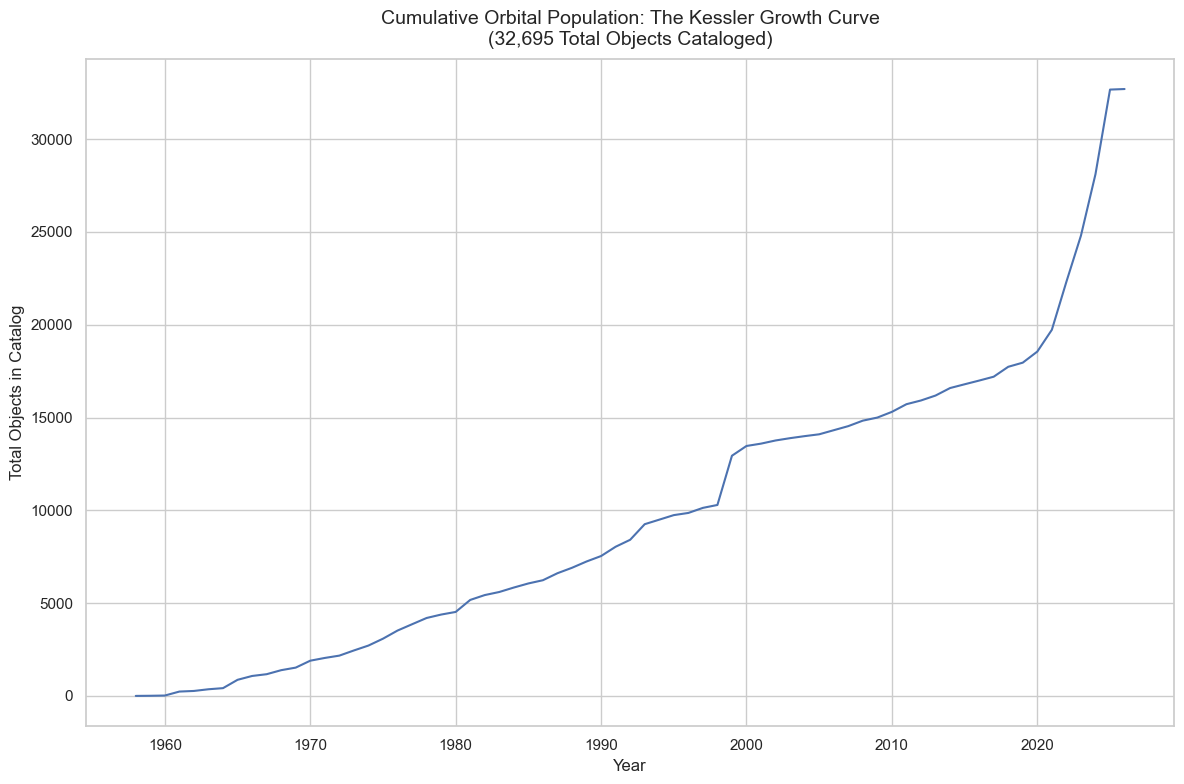

In [19]:
pop_growth = kessler_arc.groupby('launch_year').size().cumsum()
mass_growth = kessler_arc.groupby('launch_year')['launch_mass_kg'].sum().cumsum()

cumulative_growth = kessler_arc.groupby('launch_year').size().cumsum()

plt.figure(figsize=(12, 8))

plt.plot(cumulative_growth.index, cumulative_growth.values)
plt.title(f'Cumulative Orbital Population: The Kessler Growth Curve\n({len(kessler_arc):,} Total Objects Cataloged)', 
          fontsize=14, pad=10)
plt.ylabel('Total Objects in Catalog')
plt.xlabel('Year')

plt.tight_layout()

plt.savefig('../../images/kessler_growth_curve.png', dpi=300, bbox_inches='tight')

plt.show()

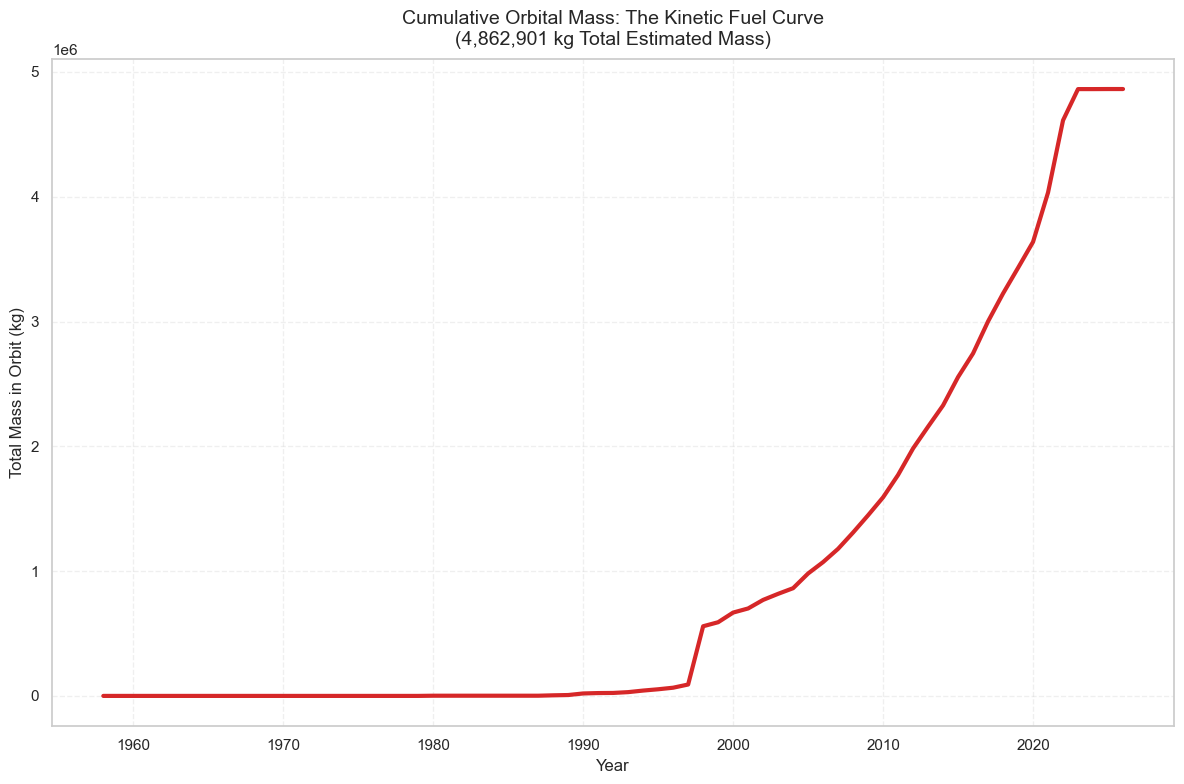

In [20]:
plt.figure(figsize=(12, 8))

plt.plot(mass_growth.index, mass_growth.values, color='tab:red', linewidth=3)

plt.title(f'Cumulative Orbital Mass: The Kinetic Fuel Curve\n({mass_growth.iloc[-1]:,.0f} kg Total Estimated Mass)', 
          fontsize=14, pad=10)

plt.ylabel('Total Mass in Orbit (kg)')
plt.xlabel('Year')

plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()

plt.savefig('../../images/cumulative_mass_curve.png', dpi=300, bbox_inches='tight')

plt.show()

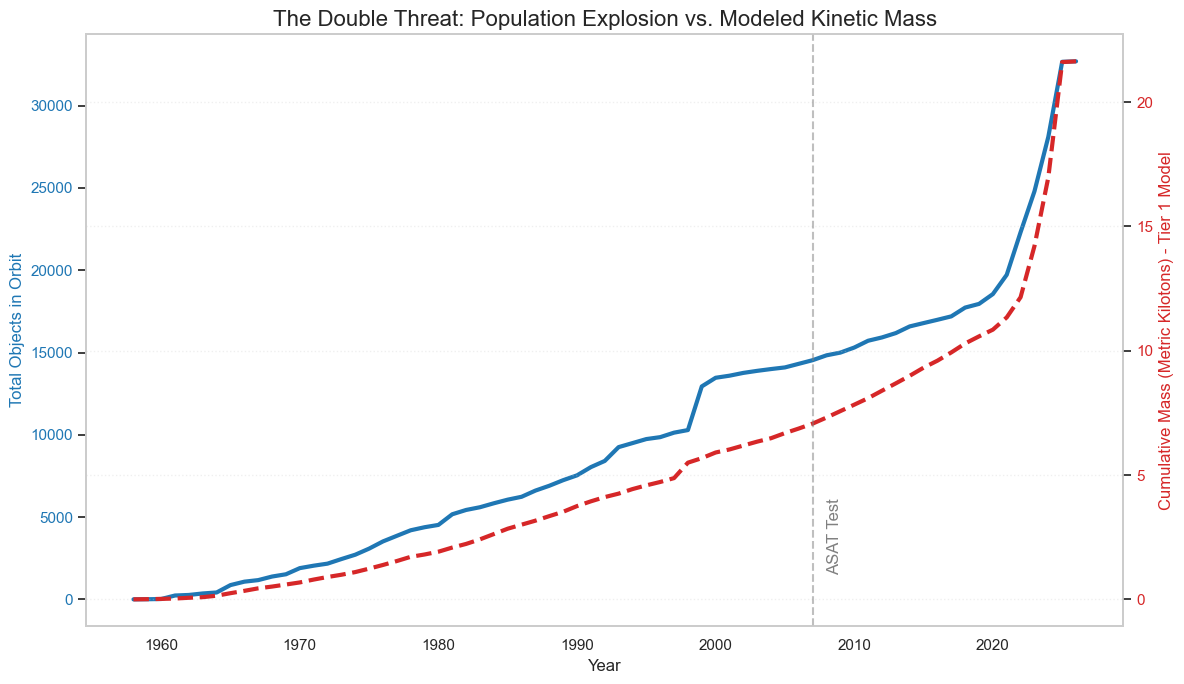

In [21]:
annual_stats = clutter_data.groupby('launch_year').agg(
    count=('object_name', 'count'),
    mass=('proxy_mass_kg', 'sum') 
).reset_index()

annual_stats['cumulative_count'] = annual_stats['count'].cumsum()
annual_stats['cumulative_mass'] = annual_stats['mass'].cumsum() / 1_000_000 # To Kilotons

fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Objects in Orbit', color=color, fontsize=12)
ax1.plot(annual_stats['launch_year'], annual_stats['cumulative_count'], color=color, linewidth=3, label='Orbital Population')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cumulative Mass (Metric Kilotons) - Tier 1 Model', color=color, fontsize=12)  
ax2.plot(annual_stats['launch_year'], annual_stats['cumulative_mass'], color=color, linewidth=3, linestyle='--', label='Modeled Kinetic Mass')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(True, linestyle=':', alpha=0.3)

plt.title('The Double Threat: Population Explosion vs. Modeled Kinetic Mass', fontsize=16)
plt.axvline(x=2007, color='grey', linestyle='--', alpha=0.5)
plt.text(2008, 1, 'ASAT Test', rotation=90, verticalalignment='bottom', color='grey')

fig.tight_layout() 
plt.savefig('../../images/double_threat.png', dpi=300) # Overwrites the old one with the new TIER 1 version
plt.show()

### **Analytical Note: The Mass Transparency Gap**

The Cumulative Mass curve presented in this study should be interpreted as a **Conservative Lower Bound Estimate**. Because high-fidelity mass data is often proprietary or classified, and largely non-existent for fragments, **82.8%** of the cataloged objects are currently assigned a mass of `NaN` in our master dataset (and treated as `0 kg` for this visualization).

In reality, the 'True' mass curve is significantly higher, driven by the thousands of unweighted Rocket Bodies and Inactive Payloads that remain in orbit.

### **Future Intentions: Solving the Gap**

To resolve the limitations identified in the **82.8% Transparency Gap**, I plan to implement a multi-tiered mass estimation model:

#### **Tier 1: Synthetic Mass Averaging**
As a baseline, we can assign standardized weights based on historical averages for known categories to create a "proxy" mass:
* **Rocket Bodies:** ~3,000 kg (Average for spent upper stages).
* **Inactive Payloads:** ~1,200 kg (Standard bus size for historical comms/science sats).
* **Debris Fragments:** ~0.5 kg (Conservative average for trackable fragments > 10cm).

#### **Tier 2: RCS-Based Kinetic Modeling (Preferred)**
To achieve higher granularity, I will explore **RCS-Based Modeling**. Radar Cross Section (RCS) provides a physical proxy for the size of an object, allowing us to estimate mass based on the object's "radar footprint" rather than a categorical average.



**The Logic of RCS Inference:**
Instead of a "one-size-fits-all" weight for debris, we use the RCS to estimate physical dimensions:
* **Small RCS:** Estimated mass ~0.1 kg (e.g., small bolts or fragments).
* **Medium RCS:** Estimated mass ~50 kg (e.g., solar panel fragments).
* **Large RCS:** Estimated mass ~1,500 kg+ (e.g., large structural panels or unlisted payloads).

**Key Advantages:**
* **Physics-Grounded:** Moves away from flat averages toward a model that scales with the actual physical size of the object.
* **Granularity:** Allows us to distinguish between a small bolt and a massive structural fragment within the "Debris" category, providing a much more accurate picture of the total "Kinetic Fuel" in orbit.

## **The Kessler Arc: Quantifying the Kinetic Threat**

While the *number* of objects in orbit tells a story of congestion, the *cumulative mass* tells the story of potential energy. This "Kessler Arc" represents the total metric tonnage of material currently in orbit. 

By treating our **82.8% Mass Transparency Gap** as $0\text{ kg}$, we establish a **Conservative Lower Bound**. Even with over 80% of the catalog effectively "weightless" in this model, the resulting curve demonstrates an alarming exponential trend.

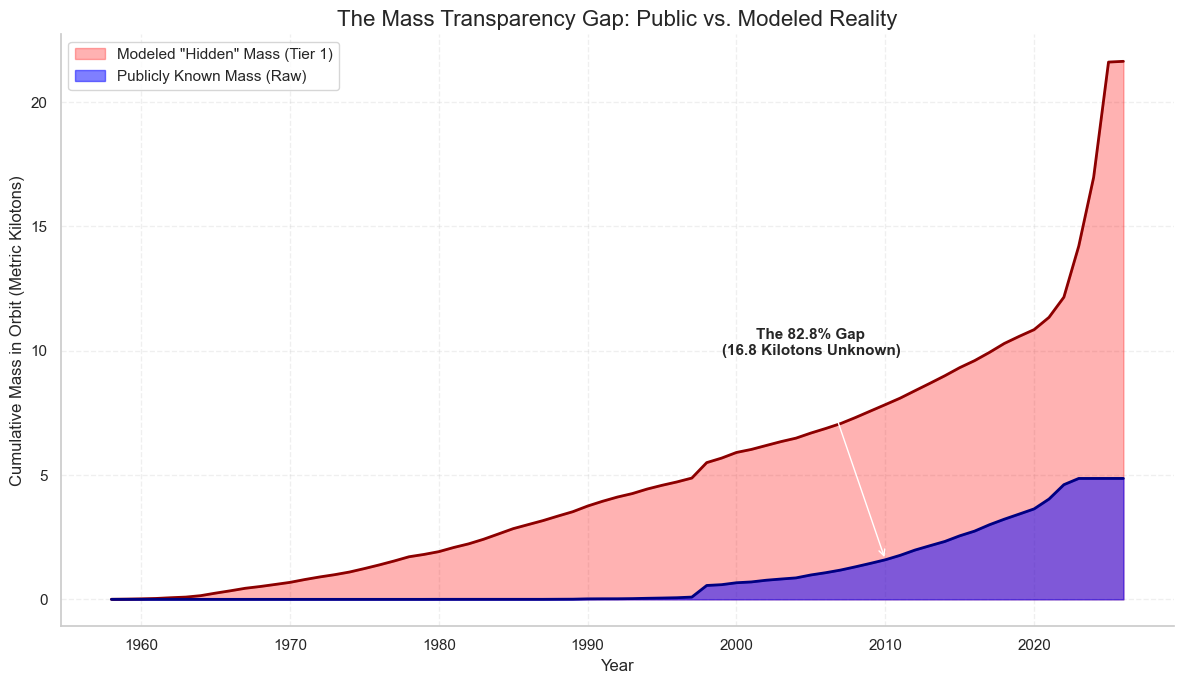

In [22]:
mass_trend = clutter_data[['launch_year', 'launch_mass_kg', 'proxy_mass_kg']].copy()

mass_trend['launch_mass_kg'] = mass_trend['launch_mass_kg'].fillna(0)
mass_trend['proxy_mass_kg'] = mass_trend['proxy_mass_kg'].fillna(0)

annual_mass = mass_trend.groupby('launch_year')[['launch_mass_kg', 'proxy_mass_kg']].sum()

cumulative_mass = annual_mass.cumsum() / 1_000_000 

fig, ax = plt.subplots(figsize=(12, 7))

ax.fill_between(cumulative_mass.index, cumulative_mass['proxy_mass_kg'], color='red', alpha=0.3, label='Modeled "Hidden" Mass (Tier 1)')
ax.plot(cumulative_mass.index, cumulative_mass['proxy_mass_kg'], color='darkred', linewidth=2)

ax.fill_between(cumulative_mass.index, cumulative_mass['launch_mass_kg'], color='blue', alpha=0.5, label='Publicly Known Mass (Raw)')
ax.plot(cumulative_mass.index, cumulative_mass['launch_mass_kg'], color='navy', linewidth=2)

plt.title('The Mass Transparency Gap: Public vs. Modeled Reality', fontsize=16)
plt.ylabel('Cumulative Mass in Orbit (Metric Kilotons)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)

last_year = cumulative_mass.index[-1]
gap_size = cumulative_mass.loc[last_year, 'proxy_mass_kg'] - cumulative_mass.loc[last_year, 'launch_mass_kg']

plt.annotate(f'The 82.8% Gap\n({gap_size:.1f} Kilotons Unknown)', 
             xy=(2010, cumulative_mass.loc[2010, 'launch_mass_kg']), 
             xytext=(2005, cumulative_mass.loc[2010, 'proxy_mass_kg'] + 2),
             arrowprops=dict(facecolor='black', arrowstyle='<->'),
             ha='center', fontsize=11, fontweight='bold')

sns.despine()
plt.tight_layout()
plt.savefig('../../images/kessler_reality_check.png') # Save this new impactful visual
plt.show()